<a href="https://colab.research.google.com/github/thenickben/pong-ppo/blob/master/pong_from_pixels_PPO_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playing Pong from pixels with Policy Gradient




In [0]:
!apt-get install python-opengl -y  >/dev/null
!apt install xvfb -y >/dev/null
!pip install pyvirtualdisplay >/dev/null
!pip install piglet >/dev/null
!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

### Utils

In [1]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

import numpy as np
import gym

In [3]:
import os 

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Folder for weights saving
path = "/content/drive/My Drive/Colab Notebooks/pong/"

In [0]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img
  
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

### Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
               

        # outputsize = (inputsize - kernel_size + stride)/stride 

        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x16
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        
        #Batchnorm
        self.bn = nn.BatchNorm1d(num_features = 256)
        
        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))


### Environment, Policy instance and Optimizer

In [0]:
#Environment
env = gym.make('PongDeterministic-v4')

#Device: cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Policy and optimizer
policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

#from torchsummary import summary
#summary(policy, input_size=(2, 80, 80))

### Collect trajectories


In [0]:
NOOP = 0
RIGHT = 4
LEFT = 5

# collect trajectories for a parallelized parallelEnv object
def collect_trajectories_v3(envs, policy, tmax=200, nrand=5):
    
    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]
    state_array = []
    
    envs.reset()
    
    envs.step(1)
    
    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT]))
        fr2, re2, _, _ = envs.step(0)
    
    for t in range(tmax):

        # prepare the input
        # preprocess_batch properly converts two frames into 
        # shape (n, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = preprocess_batch([fr1,fr2]) #torch.from_numpy(np.asarray([prepro_image_norm(fr1), prepro_image_norm(fr2)])).float().unsqueeze(0).to(device)
        
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand() < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        
        
        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step(0)

        reward = re1 + re2
       
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        state_array.append(preprocess_single(fr1))
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done:
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, action_list, reward_list, state_array


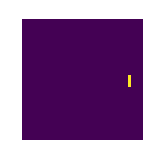
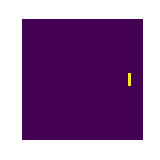
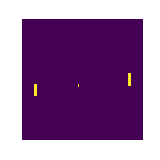
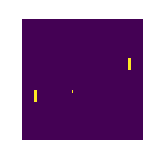
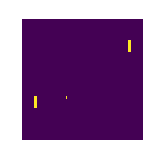
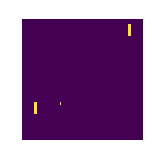
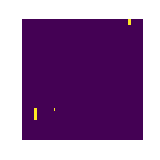
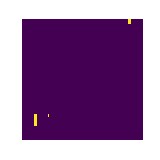
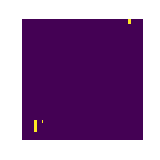
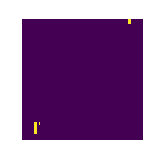
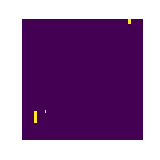
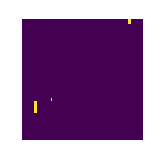
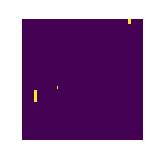
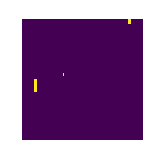
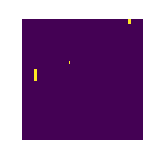
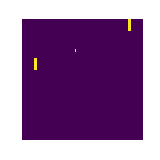
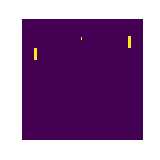
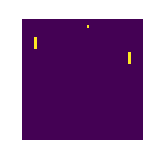
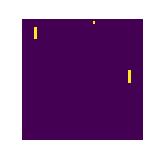
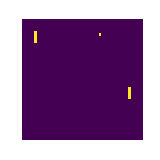
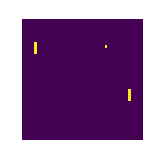
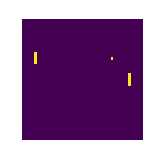
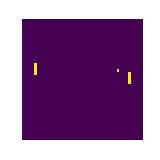
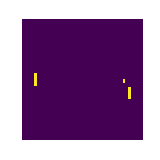
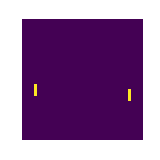
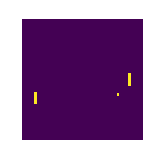
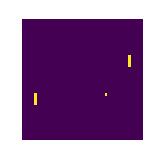
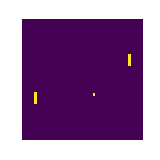
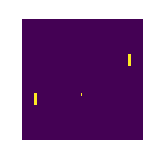
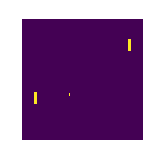
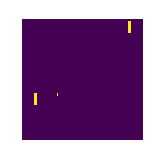
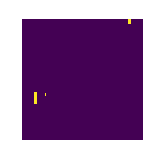
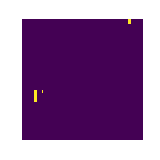
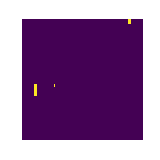
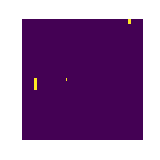
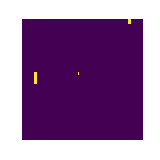
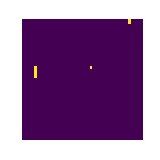
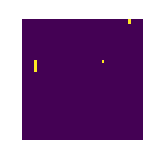
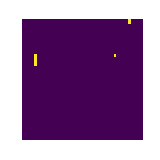
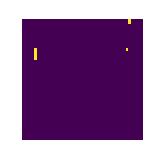
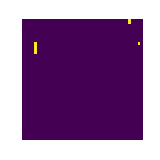
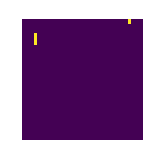
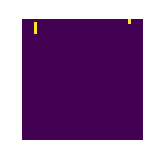
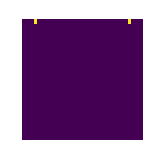
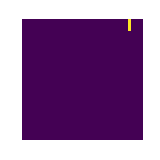
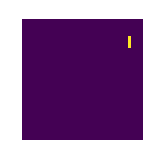
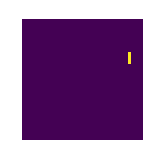
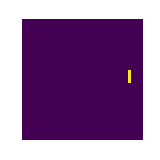
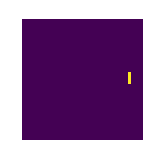
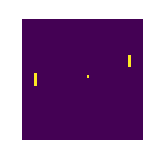
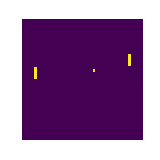
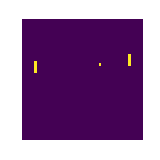
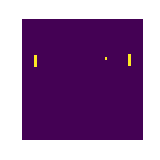
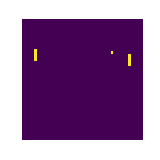
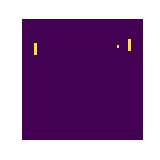
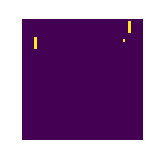
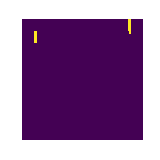
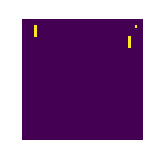
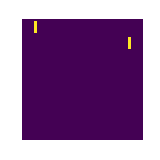
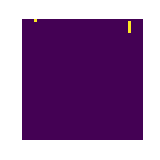
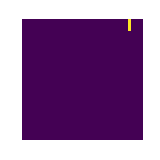
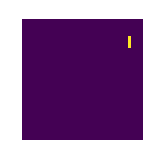
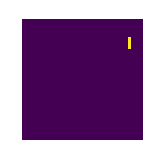
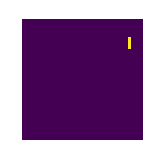
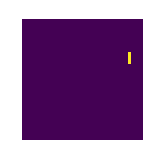
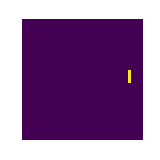
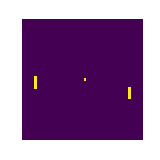
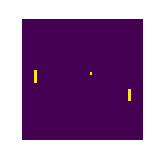
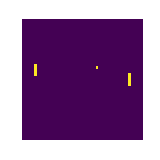
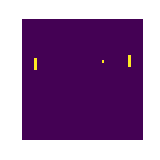
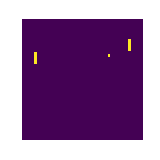
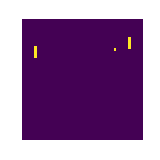
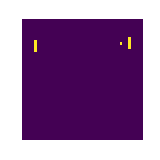
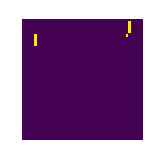
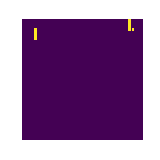
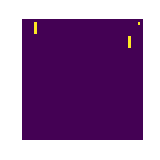
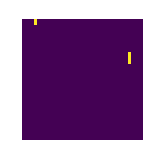
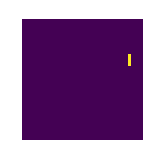
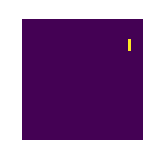
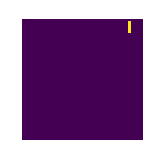
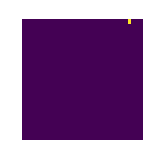
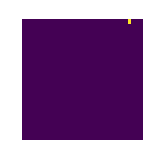
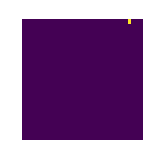
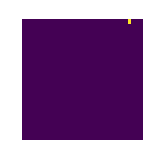
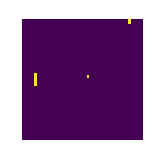
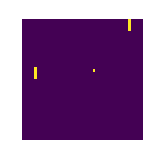
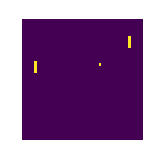
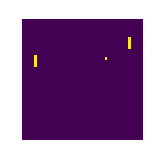
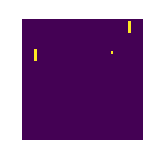
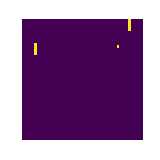
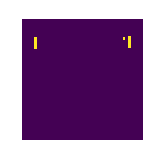
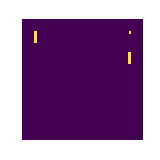
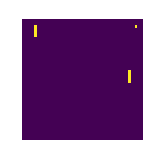
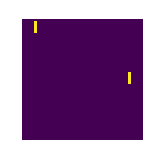
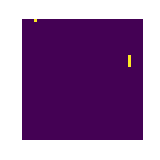
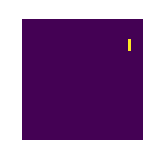
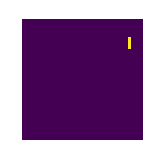
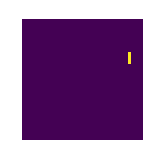
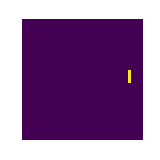
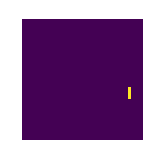
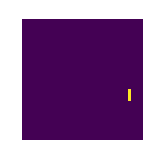
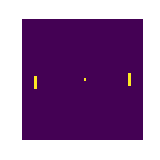
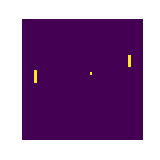
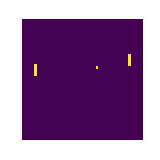
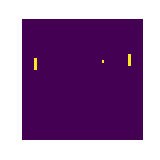
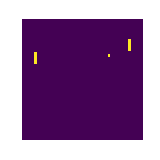
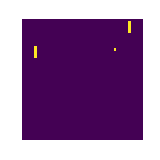
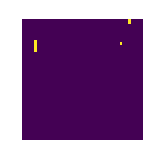
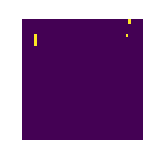
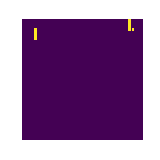
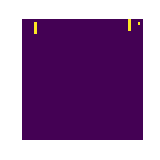
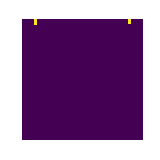
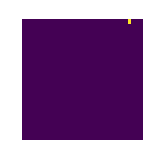
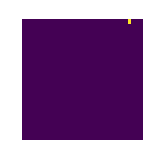
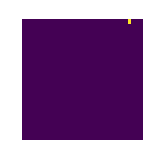
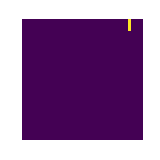
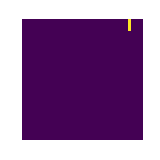
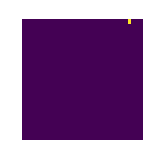
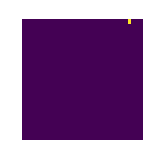
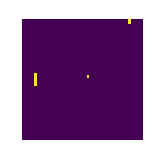
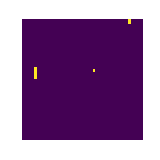
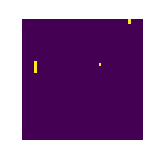
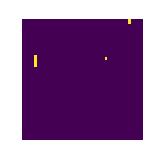
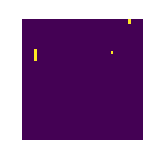
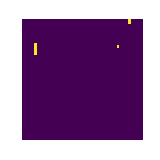
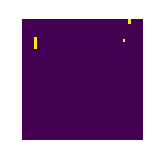
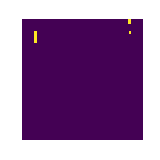
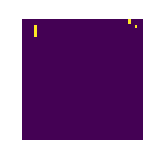
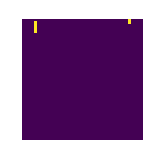
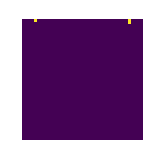
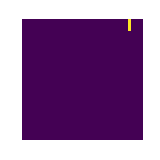
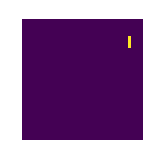
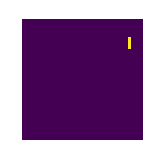
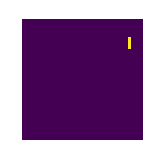
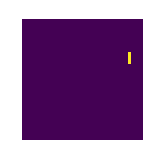
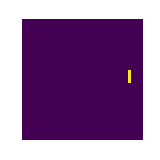
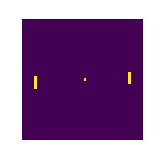
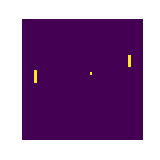
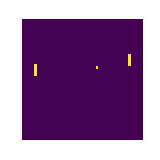
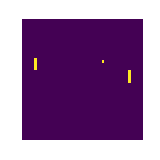
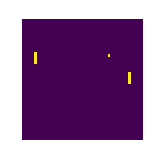
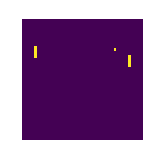
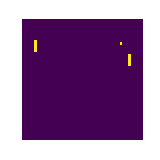
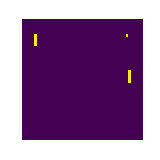
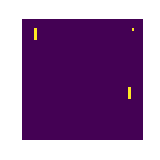
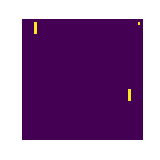
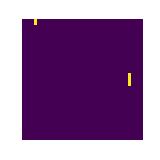
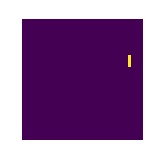
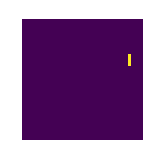
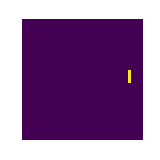
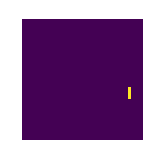
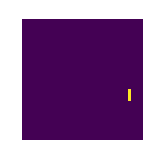
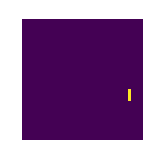
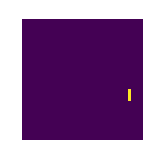
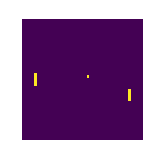
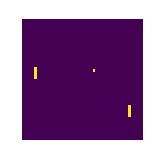
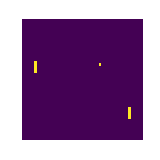
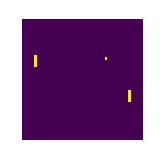
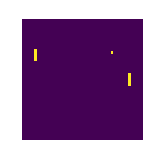
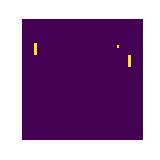
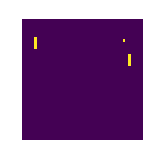
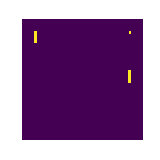
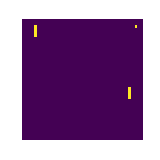
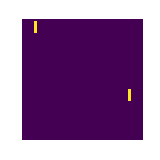
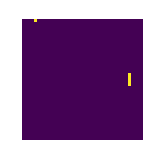
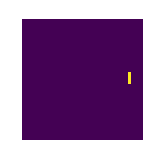
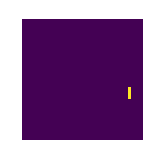
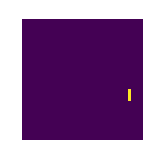
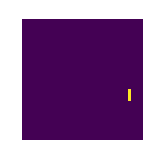
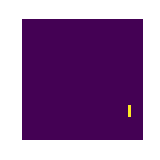
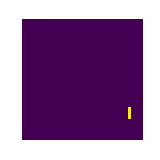
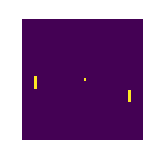
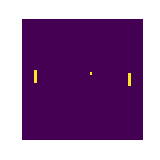
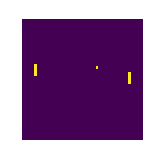
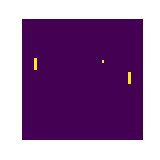
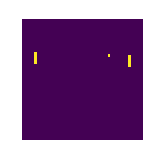
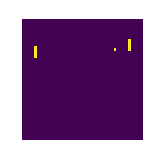
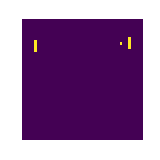
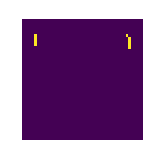
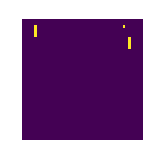
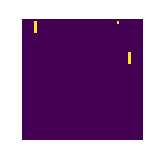
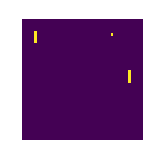
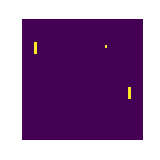
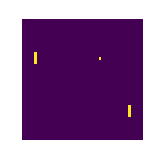
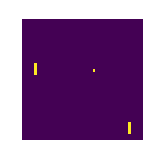
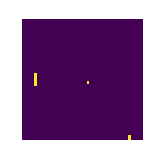
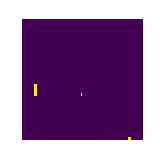
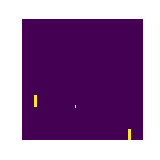
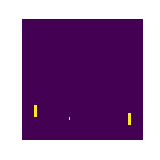
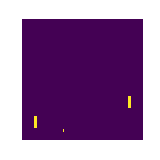
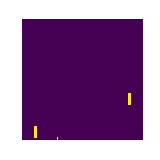
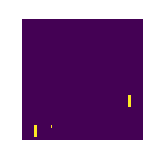
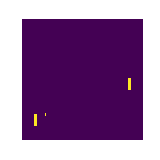
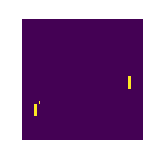
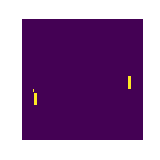
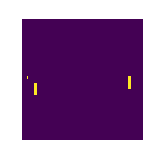
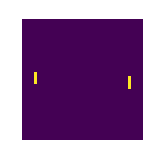
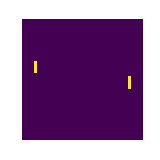
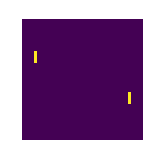
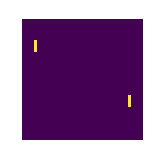

In [16]:
#Sample play
probs, states, actions, rewards, state_array = collect_trajectories_v3(env, policy,200)
display_frames_as_gif(state_array)

### Surrogate objective function

In [17]:
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.from_numpy(np.array(actions)).float().to(device)
    old_probs = torch.from_numpy(np.array(old_probs)).float().to(device)
    rewards = torch.from_numpy(np.array(rewards_normalized)).float().to(device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

#clipped_surrogate(policy, probs, states, actions, rewards)

tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)

### Training

Episode: 100, score: -5.000000
Loss: -0.006933971773833036
Episode: 200, score: -5.000000
Loss: -0.006938410922884941
Episode: 300, score: -5.000000
Loss: -0.0069338008761405945
Episode: 400, score: -3.000000
Loss: -0.00692910747602582
Episode: 500, score: -5.000000
Loss: -0.006924890913069248
Model weights saved in /content/drive/My Drive/Colab Notebooks/pong/weights_v6.pth



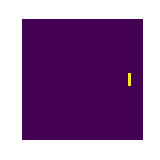
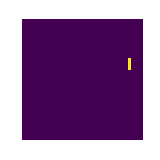
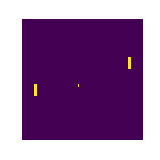
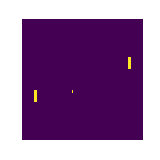
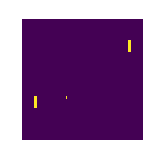
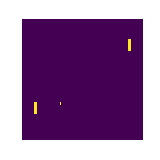
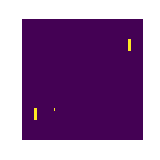
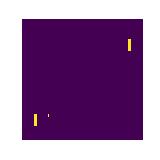
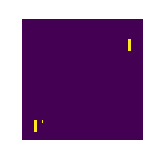
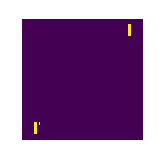
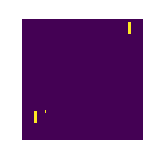
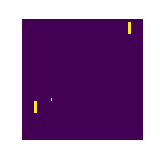
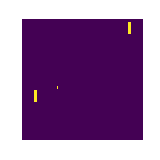
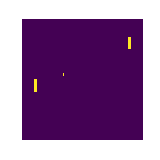
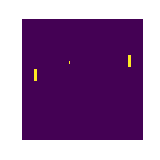
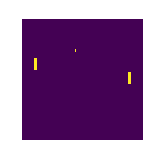
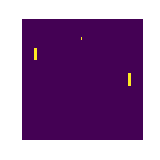
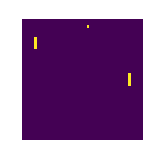
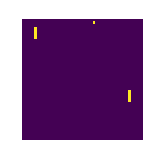
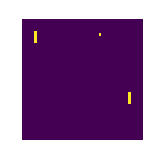
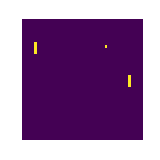
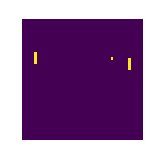
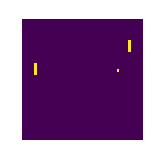
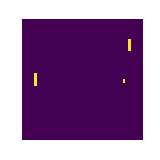
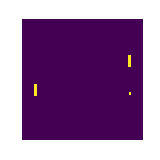
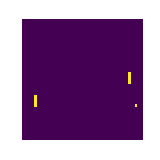
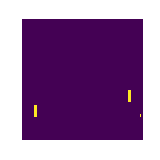
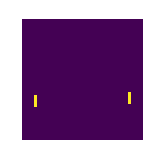
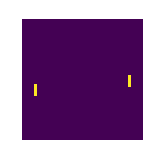
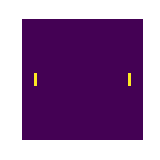
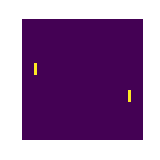
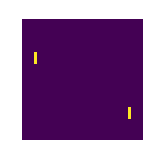
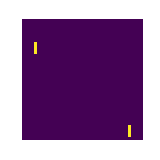
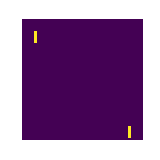
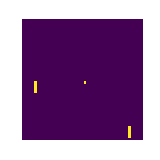
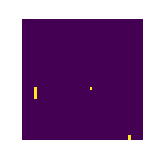
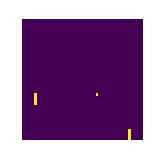
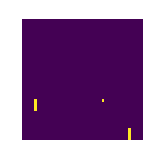
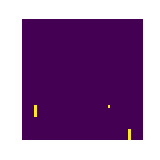
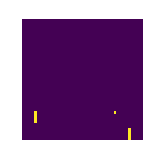
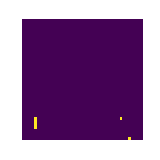
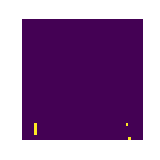
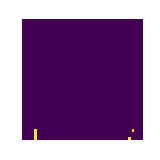
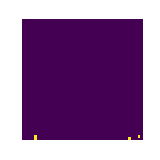
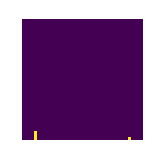
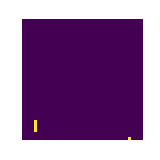
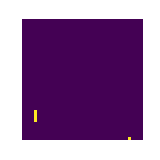
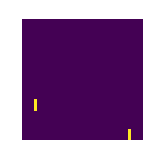
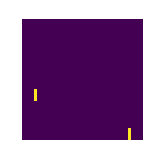
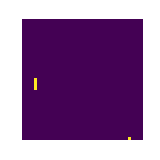
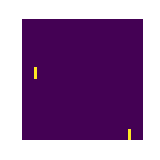
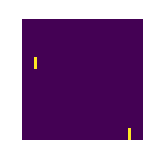
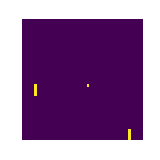
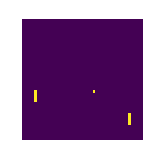
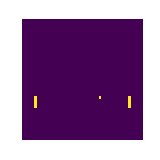
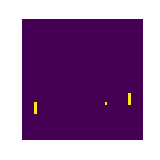
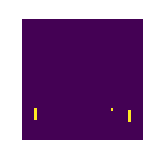
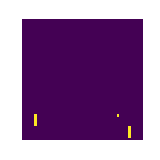
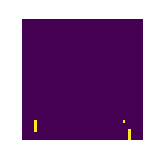
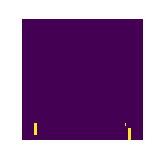
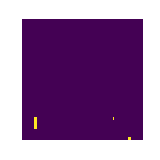
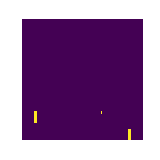
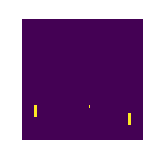
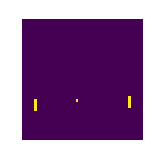
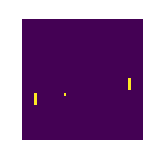
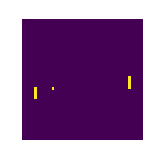
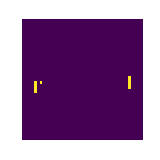
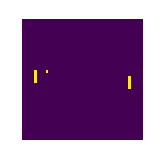
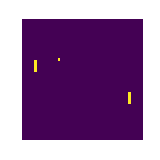
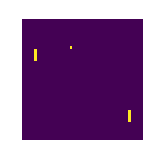
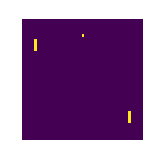
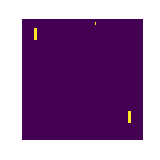
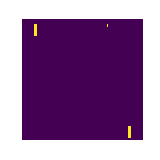
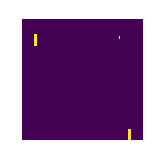
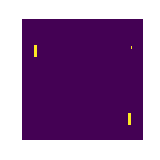
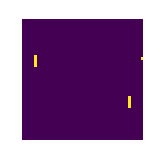
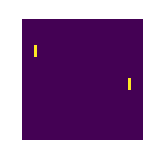
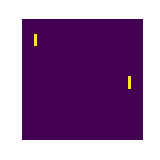
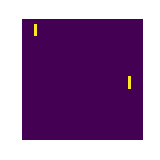
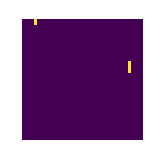
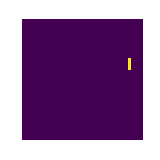
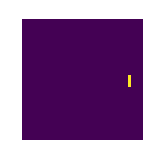
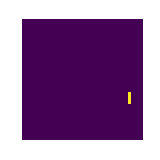
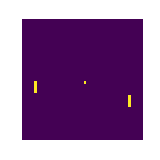
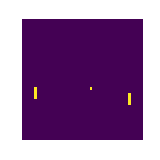
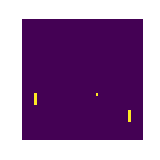
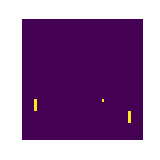
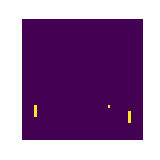
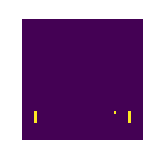
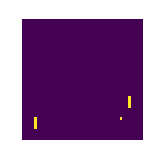
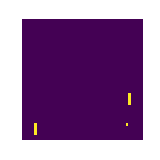
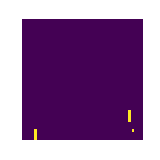
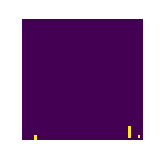
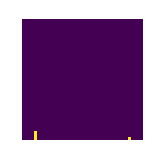
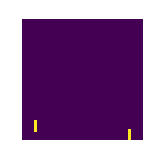
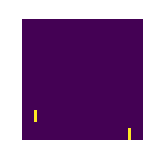
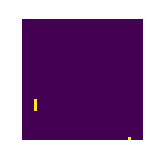
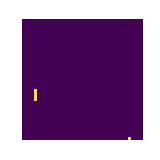
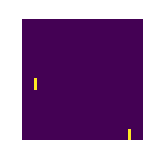
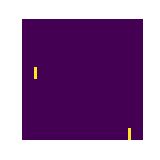
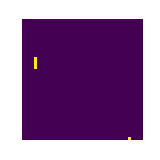
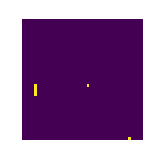
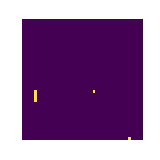
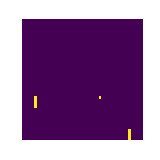
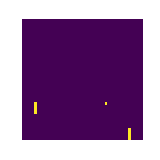
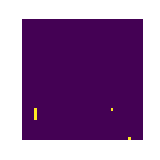
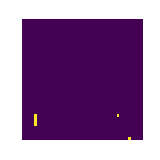
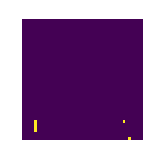
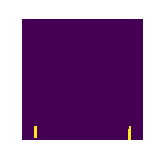
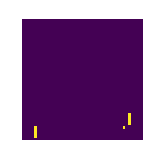
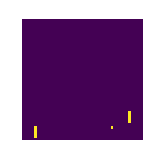
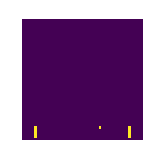
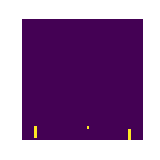
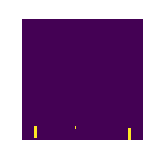
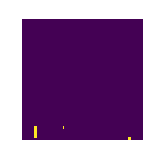
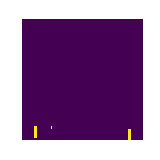
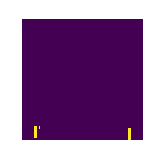
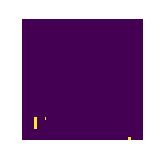
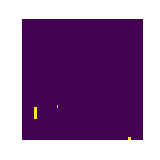
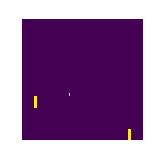
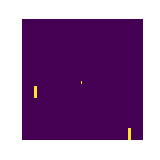
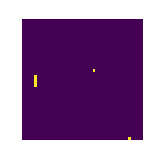
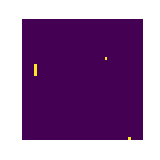
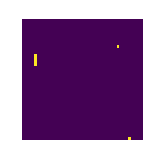
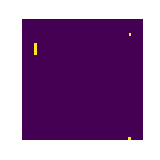
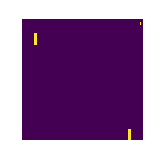
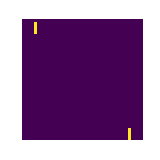
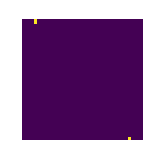
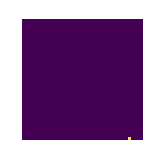
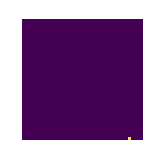
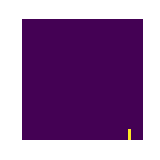
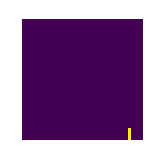
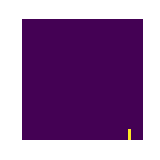
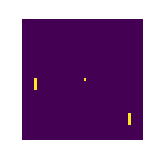
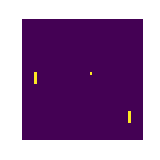
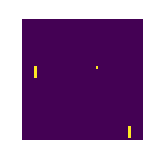
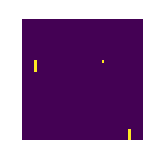
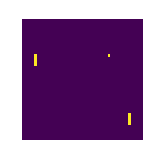
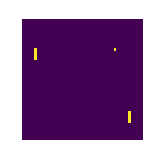
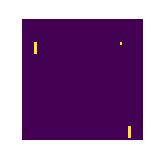
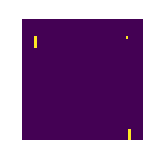
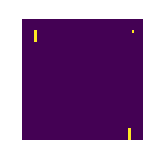
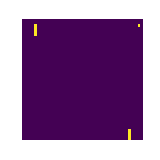
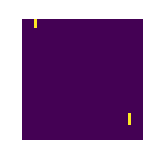
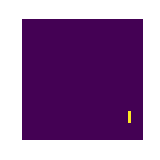
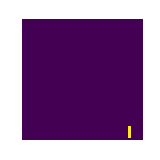
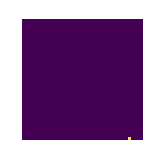
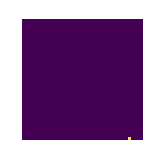
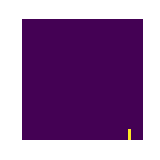
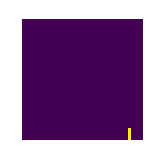
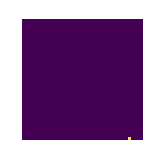
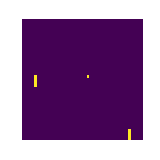
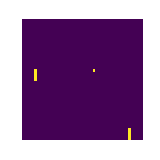
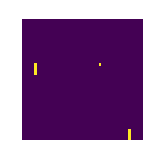
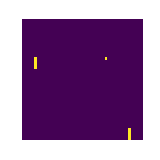
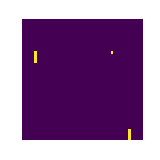
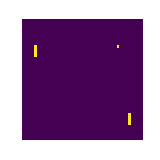
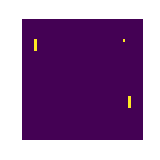
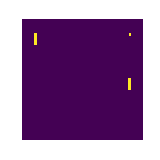
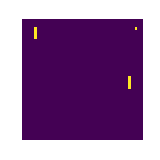
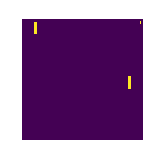
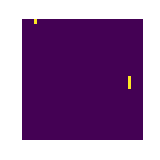
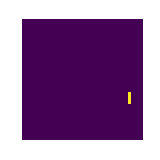
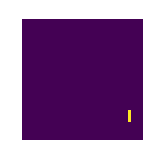
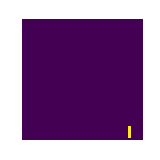
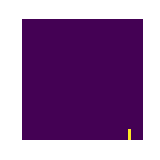
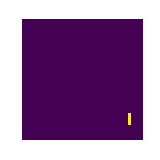
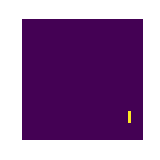
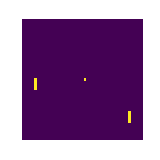
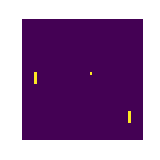
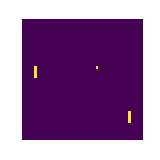
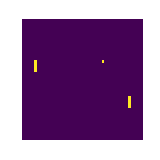
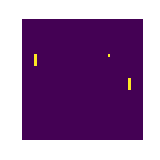
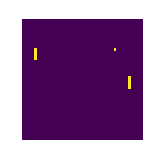
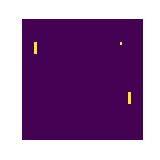
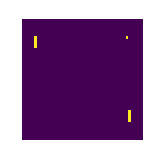
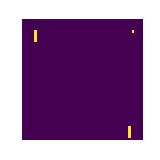
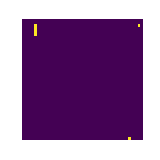
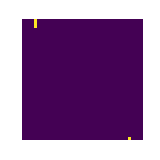
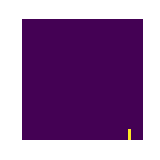
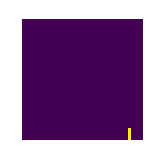
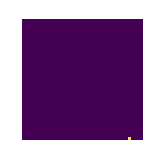
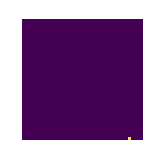
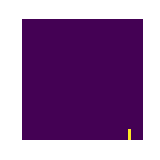
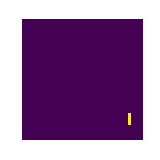
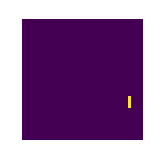
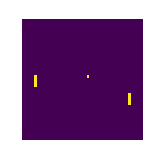
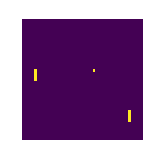
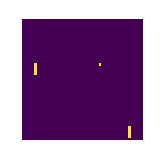
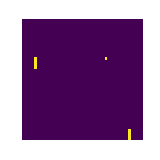
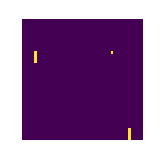
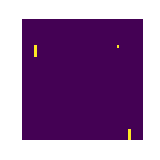
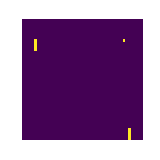
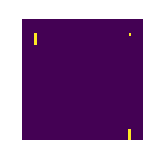
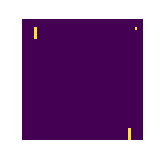
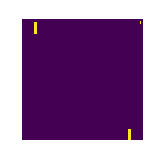
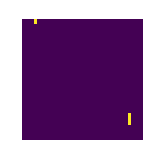
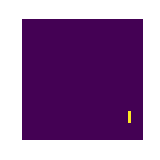
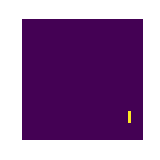
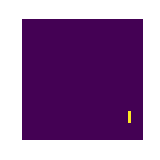

In [20]:
weights_file_name = 'weights_v6.pth'
weights_name = os.path.join(path, weights_file_name)
#policy_bn.load_state_dict(torch.load(weights_name))
#optimizer = optim.Adam(policy.parameters(), lr=1e-4)

EPISODES = 500
tmax = 100
SGD_epoch = 4
epsilon = 0.1
beta = 0.01

average_rewards = []

for i_episode in range(EPISODES):
  
  probs, states, actions, rewards, states_arr = collect_trajectories_v3(env, policy, tmax)
  
  total_rewards = np.sum(rewards, axis=0)
  
  for _ in range(SGD_epoch):
    
    loss = -clipped_surrogate(policy, probs, states, actions, rewards, epsilon, beta)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step
  
  epsilon*=.99999
  beta*=.9995
  average_rewards.append(np.mean(total_rewards))
  
  if (i_episode+1)%100 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(i_episode+1,np.mean(total_rewards)))
        print("Loss:",loss.item())
        torch.save(policy.state_dict(), weights_name)
  
  del loss
  
torch.save(policy.state_dict(), weights_name)
print('Model weights saved in', weights_name)

probs, states, actions, rewards, state_array = collect_trajectories_v3(env, policy,200)
display_frames_as_gif(state_array)